# Analyse de sensibilité globale par regression - application au cas de la déviation verticale de la poutre


# Model definition

In [1]:
import openturns as ot
import numpy as np
import pylab as pl
import openturns.viewer

In [2]:
dist_E = ot.Beta(0.9, 2.2, 2.8e7, 4.8e7)
dist_E.setDescription(["E"])
F_para = ot.LogNormalMuSigma(3.0e4, 9.0e3, 15.0e3)  # in N
dist_F = ot.ParametrizedDistribution(F_para)
dist_F.setDescription(["F"])
dist_L = ot.Uniform(250.0, 260.0)  # in cm
dist_L.setDescription(["L"])
dist_I = ot.Beta(2.5, 1.5, 310.0, 450.0)  # in cm^4
dist_I.setDescription(["I"])

X = ot.ComposedDistribution([dist_E, dist_F, dist_L, dist_I])

In [3]:
g = ot.SymbolicFunction(["E", "F", "L", "I"], ["F* L^3 /  (3 * E * I)"])
g.setOutputDescription(["Y (cm)"])

Pour pouvoir exploiter au mieux les simulations, nous équipons la fonction d'un méchanisme d'historique.

In [4]:
g = ot.MemoizeFunction(g)

Enfin, nous définissons le vecteur aléatoire de sortie.

In [5]:
XRV = ot.RandomVector(X)
Y = ot.CompositeRandomVector(g, XRV)
Y.setDescription(["Y (cm)"])

## Régression linéaire avec LinearLeastSquares

In [6]:
n = 1000
sampleX = X.getSample(n)
sampleY = g(sampleX)

In [7]:
myLeastSquares = ot.LinearLeastSquares(sampleX, sampleY)

In [8]:
myLeastSquares.run()
responseSurface = myLeastSquares.getMetaModel()
responseSurface

class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=LinearEvaluation name=Unnamed center=class=Point name=Unnamed dimension=4 values=[0,0,0,0] constant=class=Point name=Unnamed dimension=1 values=[0.000371894] linear=class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=4 columns=1 values=[-3.53343e-07,0.000422248,0.0985606,-0.0331838] gradientImplementation=class=ConstantGradient name=Unnamed constant=class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=4 columns=1 values=[-3.53343e-07,0.000422248,0.0985606,-0.0331838] hessianImplementation=class=ConstantHessian name=Unnamed constant=class=SymmetricTensor implementation=class=TensorImplementation name=Unnamed rows=4 columns=4 sheets=1 values=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

In [9]:
val = ot.MetaModelValidation(sampleX, sampleY, responseSurface)

Puisque nous utilisons le même plan d'expériences pour l'apprentissage et la validation, nous obtenons le coefficient R2 (si nous avions utilisé un plan différent pour la validation, ce coefficient se nommerait Q2). 

In [10]:
r2 = val.computePredictivityFactor()[0]
r2

0.9761937158394096

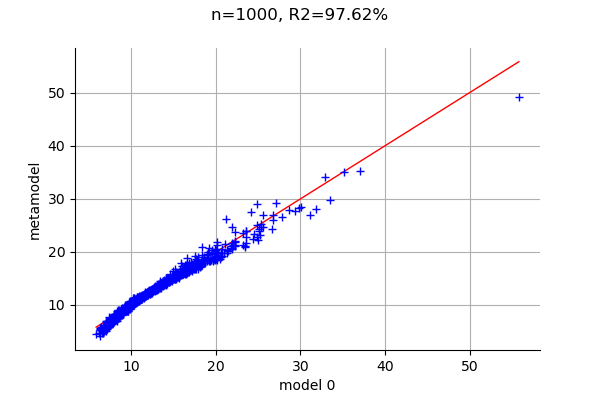

In [11]:
graph = val.drawValidation()
graph.setTitle("n=%d, R2=%.2f%%" % (n, r2 * 100))
graph

On pourrait compléter l'analyse en utilisant un second plan pour la validation, mais il s'avère que cela n'est pas nécessaire dans notre cas particulier. 

In [12]:
SRCindices = ot.CorrelationAnalysis.SRC(sampleX, sampleY)
SRCindices

class=Point name=Unnamed dimension=4 values=[0.122931,0.763083,0.00990243,0.0441961]

On observe que la somme des indices SRC retournée par `SRC` n'est pas égale à 1. 

In [13]:
SRCindices.norm1()

0.9401120609934014

Cet écart est attendu car il est associé à l'erreur d'estimation des indices par la méthode d'échantillonnage.

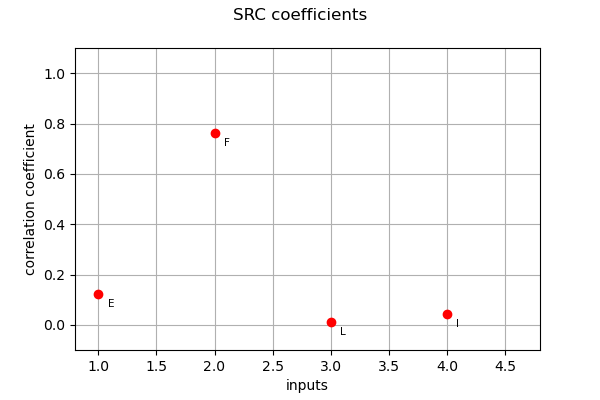

In [14]:
input_names = g.getInputDescription()
graph = ot.SobolIndicesAlgorithm.DrawCorrelationCoefficients(
    SRCindices, input_names, "SRC coefficients"
)
graph.setTitle("SRC coefficients")
graph

Nous pouvons comparer les résultats que nous avions obtenu par la méthode du développement de Taylor. 

| Méthode | E | F | L | I |
|---|---|---|---|---|
| Taylor | 0.1535 | 0.7856 | 0.0101 | 0.0508 |
| Regression | 0.1307 | 0.8117 | 0.0105 | 0.0470 |

On peut remarquer que, dans ce cas particulier, les deux méthodes donnent des résultats très similaires. En effet, 
- la méthode fondée sur le développement de Taylor fait l'hypothèse locale d'un comportement linéaire au voisinage du point moyen $E(X)$,
- la méthode fondée sur la regression linéaire fait l'hypothèse globale d'un comportement linéaire sur le domaine du vecteur aléatoire $X$.

Puisque, dans notre application, la combinaison particulière des lois marginales et de la fonction $g$ mènent à un comportement approximativement linéaire, les deux méthodes produisent des résultats similaires.

## Exercice 1 : analyse graphique sur le cas poutre

L'objectif de cet exercice est d'observer l'évolution de Y en fonction de chaque marginale $X_i$. 

- Pour `i=0,...,3`, utiliser la classe `Cloud` pour dessiner l'échantillon de points avec `sampleX[:,i]` en abscisse et `sampleY` en ordonnées.
- Observez le graphique. Quelle variable d'entrée $X_i$ semble avoir le plus d'impact sur la variabilité de la variable de sortie $Y$ ? Quelle variable d'entrée semble n'avoir aucun impact sur la variabilité de $Y$ ?

## Solution de l'exercice 1

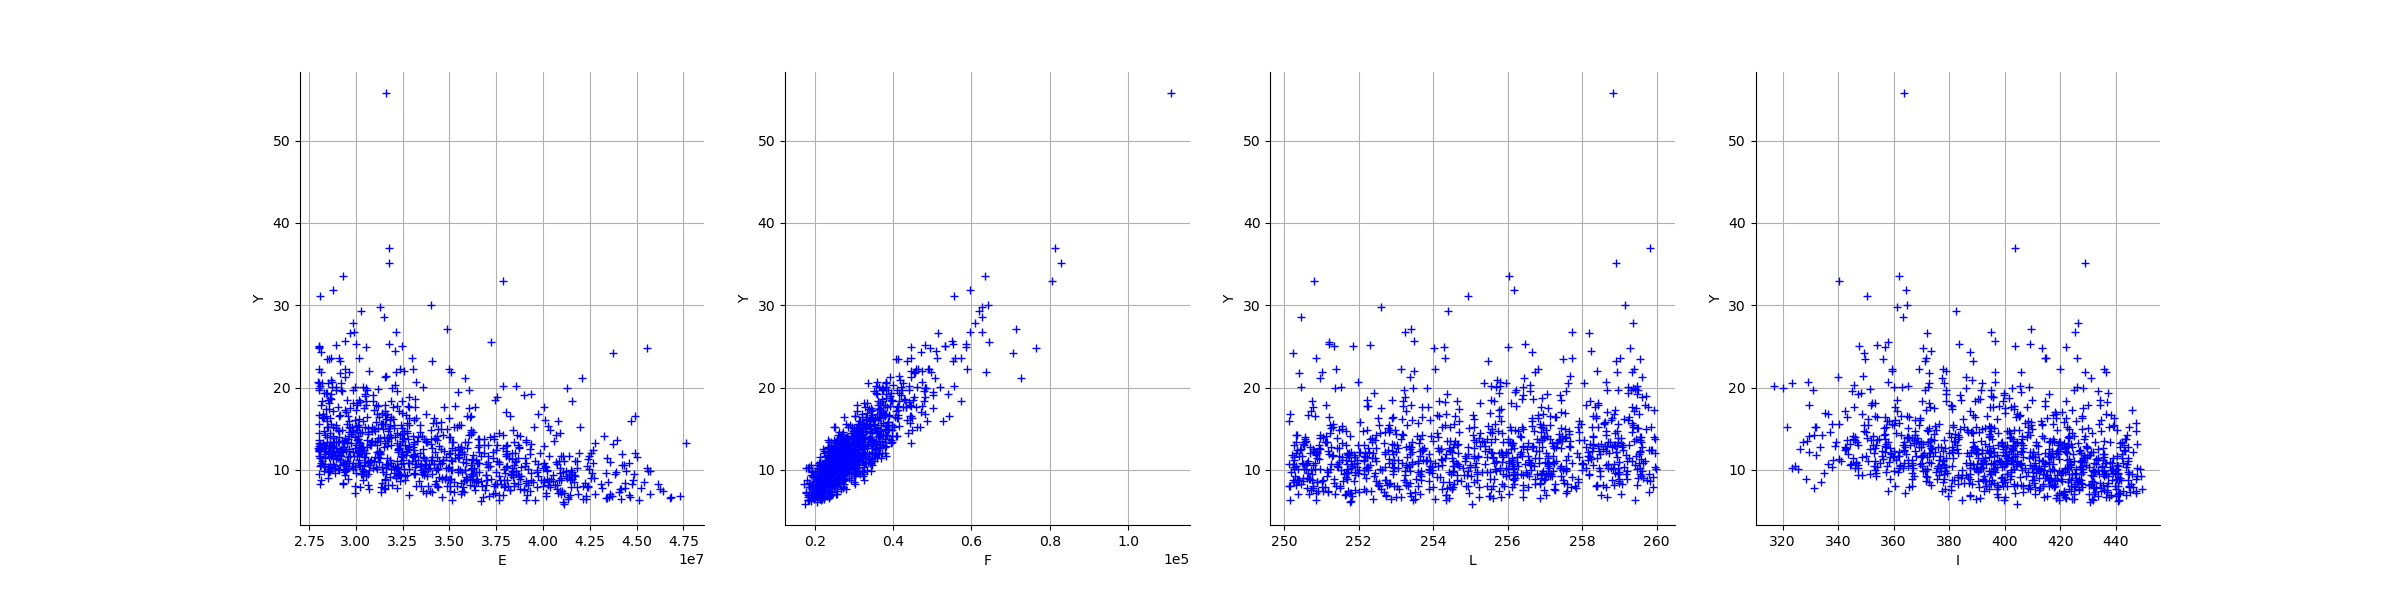

In [15]:
dimX = X.getDimension()
inputdescr = sampleX.getDescription()

grid = ot.GridLayout(1, dimX)
for i in range(dimX):
    graph = ot.Graph("", inputdescr[i], "Y", True, "")
    cloud = ot.Cloud(sampleX[:, i], sampleY)
    graph.add(cloud)
    grid.setGraph(0, i, graph)
grid

On observe que la dépendance entre Y et F est très forte : 
- les faibles valeurs de F (proches de $0.2\times 10^5$) mènent à une variable Y dont la distribution est entre 0 et 10,
- les fortes valeurs de F (proche de $0.8\times 10^5$) mènent à une variable Y dont la distribution est entre 20 et 40.

On observe au contraire que la variabilité de Y semble indépendante de L. 

## Exercice 2 : le coefficient de corrélation de Pearson

En complément des indices SRC, on utilise parfois les coefficients de corrélation de Pearson pour estimer la sensibilité :
$$
Corr(Y,X_i) = \frac{Cov(Y,X_i)}{\sqrt{V(Y)}\sqrt{V(X_i)}}
$$
pour $i=1,2,\ldots,p$.
En effet, ces coefficients permettent non seulement de quantifier la sensibilité, mais également d'obtenir le sens de variation de la sortie relativement à un changement dans chaque entrée. 
On utilise dans ce cas l'estimateur :

$$
\rho(Y,X_i) = \frac{\sum_{j=1}^n \left(y^{(j)}-\bar{y}\right)\left(x^{(j)}_i-\bar{x}_i\right)}{\sqrt{\sum_{j=1}^n \left(y^{(j)}-\bar{y}\right)^2}\sqrt{\sum_{j=1}^n \left(x^{(j)}_i-\bar{x_i}\right)^2}}
$$

pour $i=1,2,\ldots,p$, où :

$$
\bar{x}_i = \frac{1}{n} \sum_{j=1}^n x^{(j)}_i, \quad
\bar{y} = \frac{1}{n} \sum_{j=1}^n y^{(j)}.
$$

Pour hiérarchiser les variables d'entrée selon ce critère, c'est la valeur absolue du coefficient de Pearson dont on tient compte. 

L'objectif de cet exercice est de calculer les coefficients de corrélation linéaire de Pearson pour estimer la sensibilité de la sortie.
- Créer la variable `sampleXY` contenant un `Sample` de taille $n$ et de dimension 5. Remplir les 4 premières colonnes avec `sampleX` et la dernière colonne par `sampleY`.
- Utiliser la méthode `computePearsonCorrelation` pour estimer les coefficients de corrélation de Pearson. Quelle hiérarchisation se dégage de ce critère ?
- Calculer les carrés de ces coefficients ; qu'observez-vous ?
- Calculer la somme de ces carrés ; qu'observez-vous ?

## Solution de l'exercice 2 : le coefficient de corrélation de Pearson

In [16]:
sampleXY = ot.Sample(n, 5)
sampleXY[:, 0:4] = sampleX
sampleXY[:, 4] = sampleY

In [17]:
rho = sampleXY.computePearsonCorrelation()
print(rho)

5x5
[[  1         -0.014625  -0.0356988  0.0344079 -0.374176  ]
 [ -0.014625   1          0.0352995 -0.0379832  0.890172  ]
 [ -0.0356988  0.0352995  1         -0.0247714  0.148071  ]
 [  0.0344079 -0.0379832 -0.0247714  1         -0.257938  ]
 [ -0.374176   0.890172   0.148071  -0.257938   1         ]]


La dernière ligne de la matrice contient les coefficients qui relient chaque entrée à la sortie. 
- On observe que le plus fort coefficient est égal à 0.89 est celui associé à F, avec un coefficient positif. Le fait que le coefficient est positif est tout à fait évident dans le nuage de points (Y,F) précédent. 
- On observe que le second fort coefficient est égal à -0.33 est celui associé à F, avec un coefficient positif. Le fait que le coefficient est négatif n'est pas si évident dans le nuage de points (Y,E) précédent. 
- Les variables E et I ont des coefficients de corrélation proches et ont dont des effets comparables sur la sortie. 
- Avec un coefficient de corrélation linéaire égal à 0.09, la variable L semble n'avoir aucun impact sur la variabilité de la sortie.

In [18]:
for i in range(4):
    print("rho(Y,%s) = %.4f" % (inputdescr[i], rho[4, i]))

rho(Y,E) = -0.3742
rho(Y,F) = 0.8902
rho(Y,L) = 0.1481
rho(Y,I) = -0.2579


On calcule le carré des coefficients de Pearson. 

In [19]:
squaredPearsonIndices = ot.Point([rho[4, i] ** 2 for i in range(4)])
squaredPearsonIndices

class=Point name=Unnamed dimension=4 values=[0.140008,0.792406,0.021925,0.0665318]

On compare ensuite avec les coefficients SRC. 

In [20]:
SRCindices

class=Point name=Unnamed dimension=4 values=[0.122931,0.763083,0.00990243,0.0441961]

On observe que les carrés des coefficients sont très proches des facteurs d'importance. Ils seraient égaux si la taille de l'échantillon était infinie. 

En effet, d'un côté l'estimateur du facteur d'importance est :

$$
\widehat{\eta}_i = \frac{\hat{\beta}_i^2 \hat{s}_{x_i}^2}{\hat{s}_y^2}
$$

pour $i=1,\ldots, p$ où $\hat{\beta}_i$ est l'estimateur des moindres carrés linéaires, $\hat{s}_{x_i}^2$ est l'estimateur non biaisé de la variance de l'entrée $x_i$ 
et $\hat{s}_y^2$ est l'estimateur non biaisé de la variance de la sortie $y$ :

$$
\hat{s}_{x_i}^2 = \frac{1}{n - 1} \sum_{i=1}^p \left( x_i^{(j)} - \bar{x}_i \right)^2, \qquad
\hat{s}_y^2 = \frac{1}{n - 1} \sum_{i=1}^p \left( y^{(j)} - \bar{y} \right)^2.
$$

D'un autre côté, le carré du coefficient de corrélation est :

$$
r(Y,X_i)^2 = \frac{\left( \sum_{j=1}^n \left(y^{(j)}-\bar{y}\right)\left(x^{(j)}_i-\bar{x}_i\right)\right)^2}{\hat{s}_y^2 \hat{s}_{x_i}^2}
$$

pour $i=1,2,\ldots,p$.

On observe que la somme de ces carrés n'est pas exactement égale à 1. C'est un résultat attendu, car la somme des carrés des coefficients de Pearson est une variable aléatoire de moyenne égale à 1. Elle fluctue donc de part et d'autre de cette valeur. 

In [21]:
y_hat = responseSurface(sampleX)
sampleYY_hat = ot.Sample(n, 2)
sampleYY_hat[:, 0] = sampleY
sampleYY_hat[:, 1] = y_hat

rho = sampleYY_hat.computePearsonCorrelation()
print(rho)

[[ 1        0.988026 ]
 [ 0.988026 1        ]]


In [22]:
rho[0, 1] ** 2, r2

(0.9761953634072805, 0.9761937158394096)

In [23]:
residual = sampleY - y_hat
SSR = residual.computeRawMoment(2)[0]
SST = sampleY.computeCenteredMoment(2)[0]
1.0 - SSR / SST

0.9761937158394096

## Exercice 3 : application à une fonction jouet

On considère la fonction $g$ définie par :
$$
g(X_1,X_2,X_3) = X_1 (X_2-X_1)+X_3
$$
pour tout $X_1,X_2,X_3\in\mathbb{R}$. 
Les trois variables d'entrée sont supposées indépendante et suivre les lois gaussiennes spécifiées dans le tableau suivant.

| Variable | Distribution |
|---|---|
| $X_1$ | Normale($\mu_1=0.1$,$\sigma_1 = 1$) |
| $X_2$ | Normale($\mu_2=1$,$\sigma_2 = 2$) |
| $X_3$ | Normale($\mu_3=2$,$\sigma_3 = 0.2$) |

*Questions*
- Pour cette fonction, calculers les coefficients d'un modèle de régression linéaire au sens des moindres carrés.
- Ce modèle de régression est-il de bonne qualité ?

## Solution de l'exercice 3 : application à une fonction jouet

In [24]:
g = ot.SymbolicFunction(["X1", "X2", "X3"], ["X1 * (X2 - X1) + X3"])
X1 = ot.Normal(0.1, 1)
X2 = ot.Normal(1, 2)
X3 = ot.Normal(2, 0.2)
X = ot.ComposedDistribution([X1, X2, X3])
n = 1000
sampleX = X.getSample(n)
sampleY = g(sampleX)

In [25]:
myLeastSquares = ot.LinearLeastSquares(sampleX, sampleY)
myLeastSquares.run()
responseSurface = myLeastSquares.getMetaModel()
val = ot.MetaModelValidation(sampleX, sampleY, responseSurface)
q2 = val.computePredictivityFactor()[0]
q2

0.11015923977510089

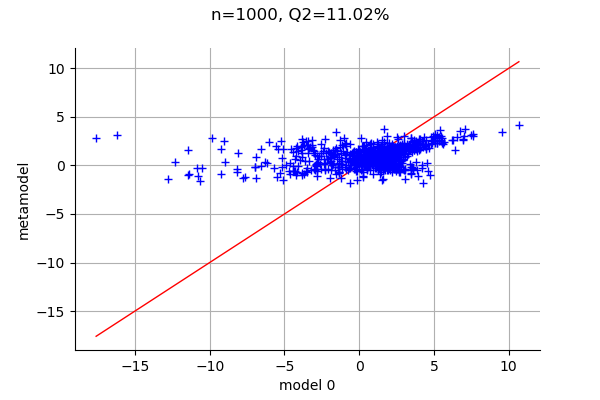

In [26]:
graph = val.drawValidation()
graph.setTitle("n=%d, Q2=%.2f%%" % (n, q2 * 100))
graph

On observe que le métamodèle est de mauvaise qualité. D'une part, le coefficient de prédictivité Q2 est égal à 15%, ce qui est médiocre. D'autre part, le graphique montre que les prédictions du métamodèle sont généralement éloignées du modèle. La cause de ces mauvaises prédictions est que le modèle n'est pas linéaire en fonction des variables d'entrée, ce que le métamodèle ignore. 

## Exercice 4 : modèle de poutre avec distributions élargies

On considère le cas de la déviation verticale de la poutre encastrée, dans lequel on modifie les paramètres des distributions marginales de $E$ et $F$. Les paramètres modifiés sont présentés dans la table ci-dessous.

|Variable|  Distribution|
| ------------- |-------------|
|E| Beta(alpha = 0.9, beta = 2.2, a = $1.0\times 10^7$, $b = 10.0\times 10^7$) |
|F| Lognormal($\mu_F=3 \times 10^4$, $\sigma_F=20\times 10^3$, shift=$15\times 10^3$)|
|L| Uniform(min=250.0, max= 260.0)|
|I| Beta(alpha = 2.5, beta = 1.5, a = 310, b = 450)|

- Calculer les paramètres du modèle de régression linéaire pour ce nouveau modèle. 
- Calculer le coefficient de prédictivité $R^2$. Comment a-t-il évolué par rapport à la situation précédente ? Pourquoi ? Que conclure ?

## Solution de l'exercice 4 : modèle de poutre avec distributions élargies

In [27]:
dist_E = ot.Beta(0.9, 2.2, 1.0e7, 10.0e7)
dist_E.setDescription(["E"])
F_para = ot.LogNormalMuSigma(3.0e4, 20.0e3, 15.0e3)  # in N
dist_F = ot.ParametrizedDistribution(F_para)
dist_F.setDescription(["F"])
X = ot.ComposedDistribution([dist_E, dist_F, dist_L, dist_I])

In [28]:
g = ot.SymbolicFunction(["E", "F", "L", "I"], ["F* L^3 /  (3 * E * I)"])
g.setOutputDescription(["Y (cm)"])

n = 1000
sampleX = X.getSample(n)
sampleY = g(sampleX)

myLeastSquares = ot.LinearLeastSquares(sampleX, sampleY)
myLeastSquares.run()
responseSurface = myLeastSquares.getMetaModel()
val = ot.MetaModelValidation(sampleX, sampleY, responseSurface)
q2 = val.computePredictivityFactor()[0]
q2

0.7239926686612792

On observe que le coefficient de prédictivité est beaucoup moins proche de 1. Une valeur aussi basse indique que le modèle est non-linéaire. La cause de ce changement est l'élargissement du domaine de variation des variables d'entrée, qui prennent plus fréquemment des valeurs éloignées des valeurs centrales. Cela implique un comportement plus éloigné du comportement local que le gradient évalué au point central prédit. En conséquence, on ne peut pas utiliser les indices SRC pour le nouveau modèle.

## Solution de l'exercice 5 : Distribution des indices SRC par bootstrap

In [29]:
dist_E = ot.Beta(0.9, 2.2, 2.8e7, 4.8e7)
dist_E.setDescription(["E"])
F_para = ot.LogNormalMuSigma(3.0e4, 9.0e3, 15.0e3)  # in N
dist_F = ot.ParametrizedDistribution(F_para)
dist_F.setDescription(["F"])
dist_L = ot.Uniform(250.0, 260.0)  # in cm
dist_L.setDescription(["L"])
dist_I = ot.Beta(2.5, 1.5, 310.0, 450.0)  # in cm^4
dist_I.setDescription(["I"])

X = ot.ComposedDistribution([dist_E, dist_F, dist_L, dist_I])

In [30]:
g = ot.SymbolicFunction(["E", "F", "L", "I"], ["F* L^3 /  (3 * E * I)"])
g.setOutputDescription(["Y (cm)"])

In [31]:
g = ot.MemoizeFunction(g)

In [32]:
XRV = ot.RandomVector(X)
Y = ot.CompositeRandomVector(g, XRV)
Y.setDescription(["Y (cm)"])

In [33]:
sample_size = 100
dimensionX = X.getDimension()
sampleX = X.getSample(n)
sampleY = g(sampleX)
SRCindices = ot.CorrelationAnalysis.SRC(sampleX, sampleY)
SRCindices

class=Point name=Unnamed dimension=4 values=[0.121332,0.778404,0.00970799,0.0481119]

In [34]:
bootstrap_size = 500
SRC_bootstrap = ot.Sample(bootstrap_size, dimensionX)
for i in range(bootstrap_size):
    indices = ot.BootstrapExperiment.GenerateSelection(sample_size, sample_size)
    sampleX_bootstrap, sampleY_bootstrap = sampleX[indices], sampleY[indices]
    SRC_bootstrap[i, :] = ot.CorrelationAnalysis.SRC(
        sampleX_bootstrap, sampleY_bootstrap
    )

In [35]:
# Compute bootstrap quantiles
alpha = 0.05
SRClow = SRC_bootstrap.computeQuantilePerComponent(alpha / 2.0)
SRCup = SRC_bootstrap.computeQuantilePerComponent(1.0 - alpha / 2.0)
SRCBounds = ot.Interval(SRClow, SRCup)

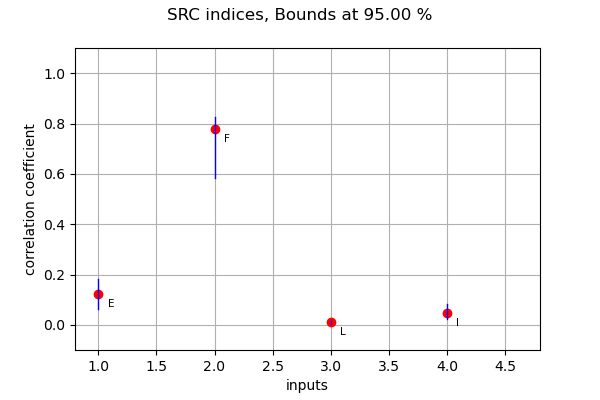

In [36]:
def plotSRCIndicesWithConfidenceIntervals(SRCindices, input_names, alpha, SRCBounds):
    """Plot SRC indices with confidence bounds"""
    dim = SRCindices.getDimension()
    lowerBounds = SRCBounds.getLowerBound()
    upperBounds = SRCBounds.getUpperBound()
    title = "SRC indices, Bounds at %.2f %%" % ((1.0 - alpha) * 100)
    # Create graph
    graph = ot.SobolIndicesAlgorithm.DrawCorrelationCoefficients(
        SRCindices, input_names, title
    )
    # Add confidence bounds
    for i in range(dim):
        curve = ot.Curve([1 + i, 1 + i], [lowerBounds[i], upperBounds[i]])
        graph.add(curve)
    return graph


plotSRCIndicesWithConfidenceIntervals(SRCindices, input_names, alpha, SRCBounds)